Following [that notebook](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial17/SimCLR.html)

In [111]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import os
from tqdm import tqdm
import cv2


%matplotlib inline

In [112]:
import torch
import torch.nn as nn
#torch functional
import torch.nn.functional as F
import torch.nn.functional as functional
import torchvision
import torchvision.transforms as transforms

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
if device=='cuda':
    print(torch.cuda.get_device_properties(0).name)

cpu


In [113]:
class ContrastiveTransformations(object):

    def __init__(self, base_transforms, n_views=2):
        self.base_transforms = base_transforms
        self.n_views = n_views

    def __call__(self, x):
        return [self.base_transforms(x) for i in range(self.n_views)]

In [114]:
original_transform = transforms.Compose([
    transforms.ToTensor()
])


contrast_transforms = transforms.Compose([
    transforms.RandomResizedCrop(size=(28, 28), scale = (0.5, 0.95)),  
    transforms.RandomRotation(degrees=45), 
    #transforms.ToTensor()
])

In [115]:
dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=original_transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)

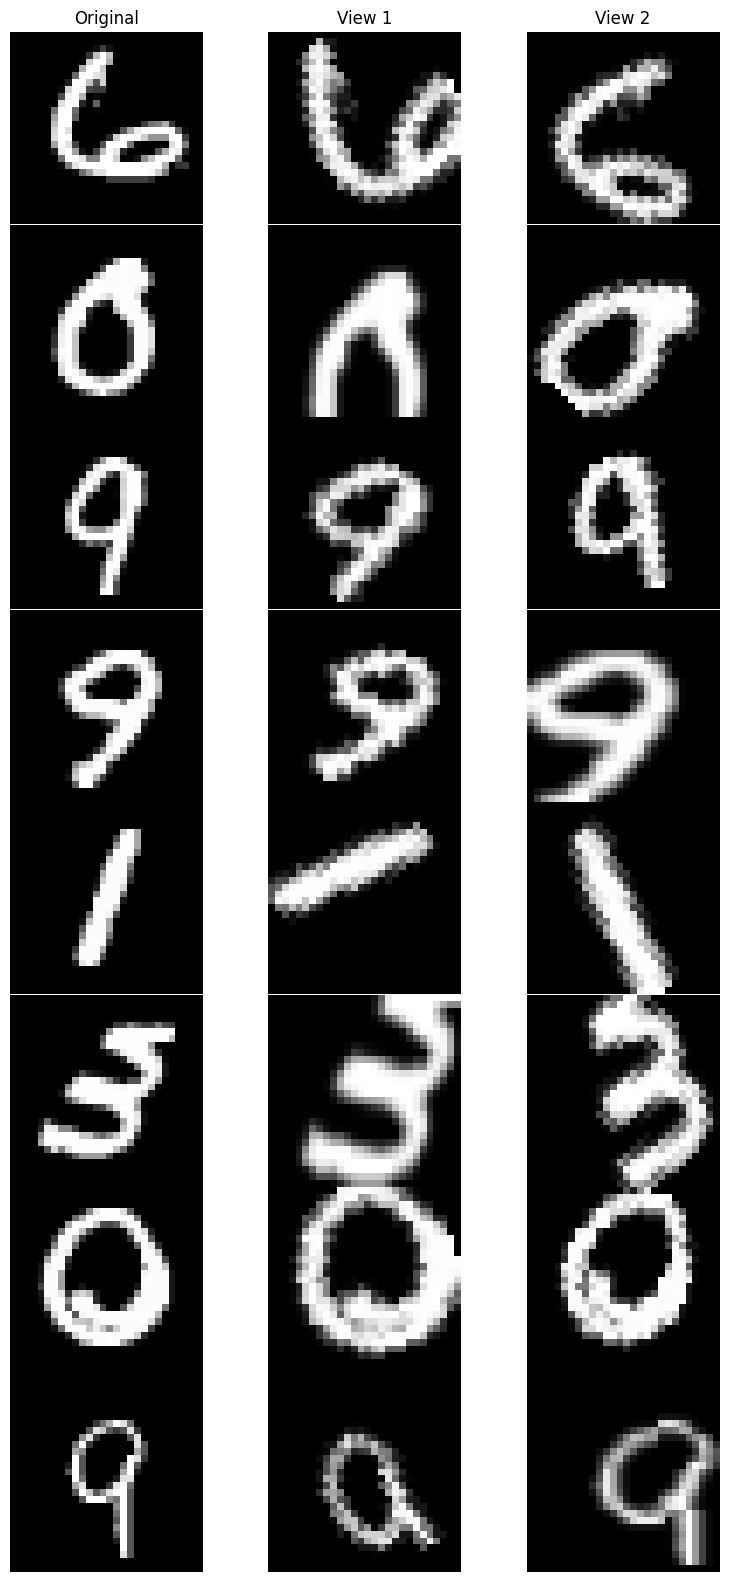

In [116]:
#plot 6 examples of original images + 2 augmented versions
batch, _ = next(iter(dataloader))

fig, axs = plt.subplots(8, 3, figsize=(10, 20))


for i in range(8):
    original = batch[i]
    axs[i, 0].imshow(original[0].numpy(), cmap='gray')
    if i==0:
        axs[i, 0].set_title('Original')
    axs[i, 0].axis('off')
    
    for j in range(1, 3):
        augmented = contrast_transforms(original)
        axs[i, j].imshow(augmented[0].numpy(), cmap='gray')
        axs[i, j].axis('off')
        if i==0:
            axs[i, j].set_title('View {}'.format(j))

#remove space between subplots
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()


In [117]:
class EncoderCNN(nn.Module):

    def __init__(self, image_channels=1, chs=(1, 3)):
        super(EncoderCNN, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 3, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(3, 6, kernel_size=2, stride=3),
            nn.ReLU(),
            nn.Flatten()
        )

    def forward(self, x):
        return self.encoder(x)


test_input = torch.randn(8, 1, 28, 28)
encoder = EncoderCNN()
output = encoder(test_input)
print(output.shape)
        

class ProjectionNN(nn.Module):

    def __init__(self, input_size=24, output_size=9):
        super(ProjectionNN, self).__init__()

        self.embedding = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, output_size)
        )

    def forward(self, x):
        return self.embedding(x)
   

projection = ProjectionNN()
output_projection = projection(output)
print(output_projection.shape)

class SimCLR(nn.Module):

    def __init__(self):
        super(SimCLR, self).__init__()

        self.encoder = EncoderCNN()
        self.projection = ProjectionNN()

    def forward(self, x):
        x = self.encoder(x)
        x = self.projection(x)
        return x
    

simclr = SimCLR()
output = simclr(test_input)
print(output.shape)


torch.Size([8, 24])
torch.Size([8, 9])
torch.Size([8, 9])


In [118]:
class NTXentLoss(nn.Module):

    def __init__(self, temperature=0.5):
        super(NTXentLoss, self).__init__()
        self.temperature = temperature
        self.criterion = nn.CrossEntropyLoss(reduction="sum")

    def forward(self, zis, zjs):
        representations = torch.cat([zis, zjs], dim=0)

        similarity_matrix = F.cosine_similarity(representations.unsqueeze(1), representations.unsqueeze(0), dim=2)

        similarity_matrix = similarity_matrix / self.temperature

        labels = torch.arange(similarity_matrix.size(0)).to(device)

        mask = torch.eye(labels.shape[0]).to(device).bool()

        labels = labels[~mask].view(labels.shape[0], -1)
        
        loss = self.criterion(similarity_matrix, labels)
        
        return loss

In [119]:
model = SimCLR().to(device)
criterion = NTXentLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [120]:
num_epochs = 10

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(dataloader):
        images = images.to(device)

        # Generate two augmented views of each image
        view_1 = contrast_transforms(images)
        view_2 = contrast_transforms(images)

        # Forward pass
        z_i = model(view_1)
        z_j = model(view_2)

        # Compute loss
        loss = criterion(z_i, z_j)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

IndexError: too many indices for tensor of dimension 1

-----